# 🐾 Analyze Pet Database using SQL (SQLite + Pandas)

In this notebook, we explore a small pet clinic database using Python and SQL (SQLite).  
We will create relational tables, insert data from CSV files, run SQL queries, and visualize the results using `seaborn` and `matplotlib`.

The structure includes:
1. Setup & Libraries
2. Create SQLite Database & Tables
3. Insert Data from CSV
4. Query & Join
5. Visualization
6. Bonus Analysis (Optional)

Let's get started!

## Setup Library

In [1]:
import sqlite3
import pandas as pd
import csv  # Used to read CSV data before inserting into SQLite

## Create SQLite Database and Tables

In [2]:
# Connect to the database
conn = sqlite3.connect("pet_clinic.db")
cursor = conn.cursor()

# Make sure foreign key constraints are enforced
cursor.execute("PRAGMA foreign_keys = ON;")

# Create table: owners
cursor.execute("""
CREATE TABLE IF NOT EXISTS owners (
    id TEXT PRIMARY KEY,
    name TEXT,
    license_status INTEGER,
    license_date_created TEXT
)
""")

# Create table: pets
cursor.execute("""
CREATE TABLE IF NOT EXISTS pets (
    pet_id TEXT PRIMARY KEY,
    pet_name TEXT,
    animal_type TEXT,
    age REAL,
    owners_id TEXT,
    FOREIGN KEY (owners_id) REFERENCES owners(id)
)
""")

## Insert Data from CSV Files

In [3]:
# Load and insert owners.csv
with open("owners.csv", "r", encoding="utf-8") as file:
    dr = csv.DictReader(file)
    to_db = [
        (
            row["id"],
            row["name"],
            int(row["license_status"]),
            row["license_date_created"]
        )
        for row in dr
    ]

cursor.executemany(
    "INSERT INTO owners (id, name, license_status, license_date_created) VALUES (?, ?, ?, ?);",
    to_db
)

# Load and insert pets.csv
with open("pets.csv", "r", encoding="utf-8") as file:
    dr = csv.DictReader(file)
    to_db = [
        (
            row["pet_id"],
            row["pet_name"],
            row["animal_type"],
            float(row["age"]),
            row["owners_id"]
        )
        for row in dr
    ]

cursor.executemany(
    "INSERT INTO pets (pet_id, pet_name, animal_type, age, owners_id) VALUES (?, ?, ?, ?, ?);",
    to_db
)

# Commit and close the connection
conn.commit()
conn.close()

## 📊 Data Analysis with SQL

Now that the data has been successfully imported into the SQLite database (`pet_clinic.db`), let's run some SQL queries to explore and analyze it.

We will use the `sqlite3` connection to run various queries, such as:

- Counting total pets and owners
- Analyzing age distributions
- Checking ownership and license status
- Finding interesting patterns in pet types and age

## Initial Data Exploration

To better understand the structure of our database, we previewed the first 5 rows from both `owners` and `pets` tables.
This gives us a quick overview of the available columns and the kind of data each table contains, which will guide our analysis and help design more insightful queries going forward.

In [4]:
# Reconnect to the database
conn = sqlite3.connect("pet_clinic.db")
cursor = conn.cursor()

# View the first 5 data from table owners
print("Owners Table Sample:")
owners_df = pd.read_sql_query("SELECT * FROM owners LIMIT 5;", conn)
print(owners_df)

# View the first 5 data from table pets
print("\nPets Table Sample:")
pets_df = pd.read_sql_query("SELECT * FROM pets LIMIT 5;", conn)
print(pets_df)

conn.close()

Owners Table Sample:
     id     name  license_status license_date_created
0  X001   Ronald               1           2025-05-04
1  X002  Willand               1           2021-01-20
2  X003   Steven               1           2024-12-30
3  X004    Wawan               0           2023-01-13
4  X005    Yusha               1           2022-08-30

Pets Table Sample:
  pet_id pet_name animal_type   age owners_id
0  p0001  Pudding         Cat  3.12      X002
1  p0002     Clay         Dog  4.25      X004
2  p0003   Morris         Dog  3.47      X001
3  p0004   Paimon         Cat  2.83      X005
4  p0005    Pluto         Cat  0.50      X004


## 📈 Query 1: Most Common Animal Types

Let’s see which types of animals are the most common in the clinic. We'll group by `animal_type` and count how many pets fall into each category.

In [5]:
query = """
SELECT animal_type, COUNT(*) AS total
FROM pets
GROUP BY animal_type
ORDER BY total DESC;
"""

with sqlite3.connect("pet_clinic.db") as conn:
    df = pd.read_sql_query(query, conn)

df

,animal_type,total
0,Cat,62
1,Dog,22
2,Bird,7
3,Horse,3
4,Squirrel,2
5,Fish,2
6,Turtle,1
7,Snake,1


## 📊 Query 2: Average Age of Pets by Animal Type

We want to analyze the average age of pets grouped by their animal type. This helps us understand age distributions across different pet species.

In [6]:
query = """
SELECT animal_type, ROUND(AVG(age), 2) AS average_age
FROM pets
GROUP BY animal_type
ORDER BY average_age DESC;
"""

with sqlite3.connect("pet_clinic.db") as conn:
    df = pd.read_sql_query(query, conn)

df

,animal_type,average_age
0,Turtle,10.50
1,Fish,9.25
2,Horse,8.93
3,Cat,7.08
4,Bird,6.20
5,Dog,6.06
6,Snake,5.70
7,Squirrel,3.30


## 🐶📊 Visualization: Distribution of Pet Ages by Animal Type

To better understand the age spread of pets, we visualize it using a boxplot. This shows us the median, range, and possible outliers for each type of animal.

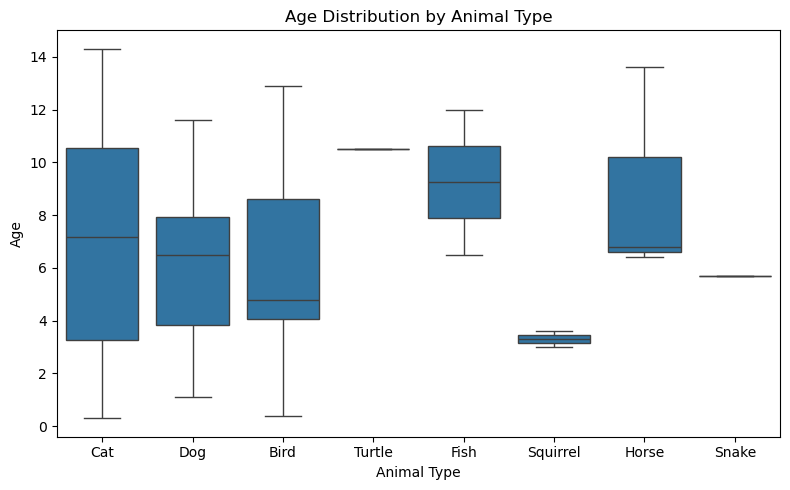

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Reconnect and load data
conn = sqlite3.connect("pet_clinic.db")
pets_df = pd.read_sql_query("SELECT * FROM pets;", conn)
conn.close()

plt.figure(figsize=(8,5))
sns.boxplot(data=pets_df, x="animal_type", y="age")
plt.title("Age Distribution by Animal Type")
plt.xlabel("Animal Type")
plt.ylabel("Age")
plt.tight_layout()
plt.show()

### 📊 Insight from the Boxplot  
  
From the visualization above, we can observe the following:
  
- **Cats** show the widest age spread overall, ranging from very young to nearly **15 years** old.  
- **Dogs** and **Birds** follow with moderately wide distributions, indicating a variety of age groups among these common pets.  
- **Fish** and **Horses** also show noticeable variation in age, though not as wide as cats.  
- **Turtles** and **Snakes** appear as **single-value entries** (no boxes), likely indicating only **one individual** for each — so we can’t draw conclusions about their age distributions.  
- **Squirrels**, while present in small numbers, have **more than one record**, shown by a visible (though compact) box.  
- The **median age** for most animals lies between **6 and 9 years**, depending on the type.  
  
These patterns give us a clearer idea of the variety of animals treated at the clinic, and help identify which groups might need more tailored care.  
  
⚠️ *Note:* This is a simulated dataset and does not reflect real-world animal lifespans.  
  
> 🐍 *Fun Fact:* Snakes can live for decades in the wild — just don’t expect them to fetch your slippers.  
> Meanwhile, my cactus still hasn’t recovered from its traumatic week of neglect. 🌵

## 🧾 Query 3: Number of Pets per Owner

Let’s find out how many pets each owner has. We’ll join the `pets` table with `owners`, and count pets grouped by `owners.name`.

In [8]:
query = """
SELECT o.name AS owner_name, COUNT(p.pet_id) AS total_pets
FROM owners o
LEFT JOIN pets p ON o.id = p.owners_id
GROUP BY o.name
ORDER BY total_pets DESC;
"""

with sqlite3.connect("pet_clinic.db") as conn:
    df = pd.read_sql_query(query, conn)

df

,owner_name,total_pets
0,Yusha,22
1,Ronald,16
2,Willand,15
3,Rosgi,15
4,Mardis,12
5,Wawan,11
6,Steven,9


### Query 4: License Status Distribution of Pet Owners

We want to examine how many pet owners have an active license versus an inactive one. This could help understand license compliance across the dataset. Although the sample size is small, visualizing the status distribution gives us an idea of how well owners keep their pet licenses up to date.

In [9]:
query = """
SELECT license_status, COUNT(*) AS total
FROM owners
GROUP BY license_status;
"""

with sqlite3.connect("pet_clinic.db") as conn:
    df = pd.read_sql_query(query, conn)

df.head()

,license_status,total
0,0,3
1,1,4


## 🪪📊 Visualization: Owner License Status Breakdown

A quick pie chart to visualize how many owners have active versus inactive licenses.

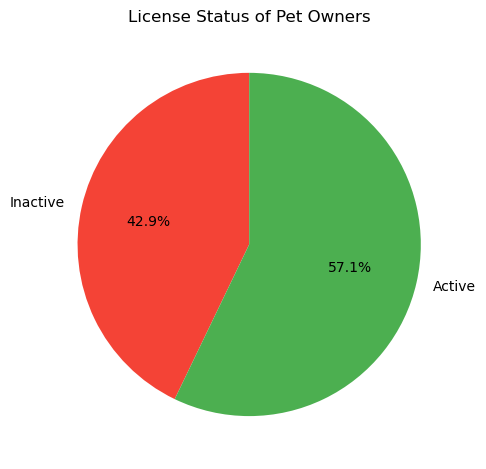

In [10]:
# Reconnect and get data
conn = sqlite3.connect("pet_clinic.db")

# Query grouped license status counts
license_df = pd.read_sql_query("""
    SELECT license_status, COUNT(*) AS total
    FROM owners
    GROUP BY license_status;
""", conn)

conn.close()

# Map binary status to descriptive labels
license_df["status"] = license_df["license_status"].map({0: "Inactive", 1: "Active"})

# Plot pie chart
plt.figure(figsize=(5,5))
plt.pie(
    license_df["total"],
    labels=license_df["status"],
    autopct="%1.1f%%",
    colors=["#F44336", "#4CAF50"],  # red for Inactive, green for Active
    startangle=90
)
plt.title("License Status of Pet Owners")
plt.tight_layout()
plt.show()

Based on the chart, we can observe that approximately 57.1% of pet owners have an active license, while 42.9% have inactive licenses.
This suggests that license compliance may need further attention, especially if maintaining an active license is required.

For future exploration, we could analyze why some owners hold inactive licenses — for instance, by investigating when their license was last updated (`license_date_created`), or checking whether inactive licenses correlate with specific pet types.

> 💡 **Future idea:** Explore potential correlations between license status and pet type, or visualize license activity trends using `license_date_created`.

## 🐾 Query 5: Finding All Pets Belonging to a Specific Owner (e.g. Willand)

Sometimes, a pet owner may forget all the animals they have registered at the clinic.  
For example, suppose we want to find all pets belonging to a person named *Willand*.  
From the owners table, we previously saw that his ID is `'X002'`.  
Let’s fetch all the pet records connected to him:

In [11]:
query = """
SELECT pet_id, 
       pet_name,
       animal_type
FROM pets
WHERE owners_id = 'X002';
"""

with sqlite3.connect("pet_clinic.db") as conn:
    df = pd.read_sql_query(query, conn)

df

,pet_id,pet_name,animal_type
0,p0001,Pudding,Cat
1,p0009,Simba,Cat
2,p0013,Snowy,Cat
3,p0031,Butterscotch,Dog
4,p0054,Marshy,Cat
5,p0059,Kiki,Bird
6,p0064,Wiggles,Cat
7,p0067,Peanut,Horse
8,p0075,Jelly,Cat
9,p0077,Peppy,Cat


> 😹 *Note:* Willand’s pet list reminds us of a Pokémon trainer — gotta register 'em all!


### Notes:
- The data is sourced from two CSV files: `owners.csv` and `pets.csv`.
- A new SQLite database (`pet_clinic.db`) is created each time the notebook is run from the beginning.
- The table structure follows a basic relational schema between pet owners and their pets.

> 💡 *Optional:* If you want to restart the notebook from scratch (e.g., recreate the database from CSV), please run the code cell below to delete the existing `pet_clinic.db` file.

In [ ]:
import os

# Close connection if still open
try:
    conn.close()
except:
    pass  # ignore if already closed

# Delete the DB file
db_path = "pet_clinic.db"

if os.path.exists(db_path):
    os.remove(db_path)
    print("✅ pet_clinic.db has been deleted. You can now re-run the notebook from the top.")
else:
    print("⚠️ pet_clinic.db not found.")

---

## 🔚 End of Notebook
This notebook has completed all database creation and analysis steps.
Feel free to explore or modify further if needed.